In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seglearn.transform import InterpLongToWide, SegmentX, FeatureRep
from seglearn.pipe import Pype

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GroupKFold
%matplotlib inline

In [2]:
data = np.load("./sensor_data/nar.npy", allow_pickle=True).item()
data_clean = np.load("./sensor_data/nar.npy", allow_pickle=True).item()

In [13]:
X = np.array(data['X'])
y = data['exnum']
subject = data['subject']

fs = 0.02 # 20 ms
width = int(4.0 / fs) # 4s
overlap = 0.5

mdl = Pype([('interp', InterpLongToWide(sample_period=fs)),
            ('segment', SegmentX(width, overlap)),
            ('ftr', FeatureRep()),
            ('scaler', StandardScaler()),
            ('clf', RandomForestClassifier())])

gkf = GroupKFold(n_splits=3)
for i, (train, test) in enumerate(gkf.split(X, y, groups=subject)):
    print("Running on fold: ", i)    
    mdl.fit(X[train], y[train])
    acc = mdl.score(X[test], y[test])
    print("Accuracy: ", acc)

Running on fold:  0


ValueError: Unique identifier var_types not consistent between time series

In [3]:
# cleaning the data
keys = data_clean.keys()
i = 0
while len(data_clean['X']) != i:
    if len(set(list(data_clean['X'][i][...,1]))) != 3:
        for key in keys:
            current = data_clean[key]
            if key == 'X':
                _ = current.pop(i)
            elif key == 'y_labels':
                pass
            else:
                removed = np.delete(current, i)
                data_clean[key] = removed
    else:
        i += 1

In [4]:
# original
print("ORIGINAL")
print(f"Keys: {data.keys()}")
print("Types")
for key in data.keys():
    print(f"{key}: {type(data[key])}")
    if type(data[key]) is list:
        print(f"len: {len(data[key])}")

    else:
        print(f"shape: {data[key].shape}")

ORIGINAL
Keys: dict_keys(['X', 'subject', 'side', 'quality', 'exnum', 'y_labels'])
Types
X: <class 'list'>
len: 1252
subject: <class 'numpy.ndarray'>
shape: (1252,)
side: <class 'numpy.ndarray'>
shape: (1252,)
quality: <class 'numpy.ndarray'>
shape: (1252,)
exnum: <class 'numpy.ndarray'>
shape: (1252,)
y_labels: <class 'list'>
len: 9


In [5]:
for i in range(len(data['X'])):
    if len(set(list(data['X'][i][...,1]))) != 3:
        print(i, set(list(data['X'][i][...,1])))
    

175 {2.0, 4.0}
606 {2.0, 4.0}


In [6]:
# clean data
print("CLEANED")
print(f"Keys: {data_clean.keys()}")
print("Types")
for key in data_clean.keys():
    print(f"{key}: {type(data_clean[key])}")
    if type(data_clean[key]) is list:
        print(f"len: {len(data_clean[key])}")

    else:
        print(f"shape: {data_clean[key].shape}")

CLEANED
Keys: dict_keys(['X', 'subject', 'side', 'quality', 'exnum', 'y_labels'])
Types
X: <class 'list'>
len: 1250
subject: <class 'numpy.ndarray'>
shape: (1250,)
side: <class 'numpy.ndarray'>
shape: (1250,)
quality: <class 'numpy.ndarray'>
shape: (1250,)
exnum: <class 'numpy.ndarray'>
shape: (1250,)
y_labels: <class 'list'>
len: 9


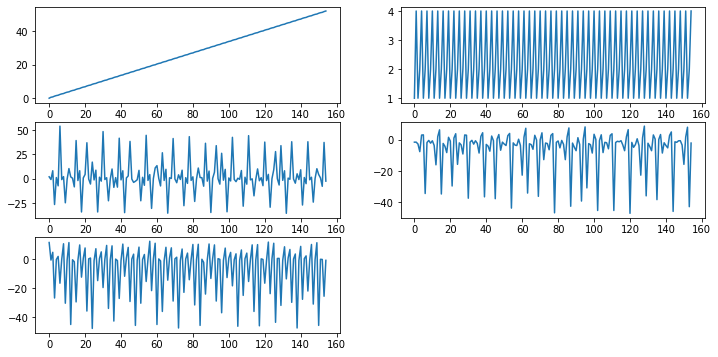

In [7]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(3, 2, 1)
plt.plot(data_clean['X'][0][:, 0][0::100])
fig.add_subplot(3, 2, 2)
plt.plot(data_clean['X'][0][:, 1][0::100])
fig.add_subplot(3, 2, 3)
plt.plot(data_clean['X'][0][:, 2][0::100])
fig.add_subplot(3, 2, 4)
plt.plot(data_clean['X'][0][:, 3][0::100])
fig.add_subplot(3, 2, 5)
plt.plot(data_clean['X'][0][:, 4][0::100])

In [8]:
data_clean['X'][0].shape

(15482, 5)

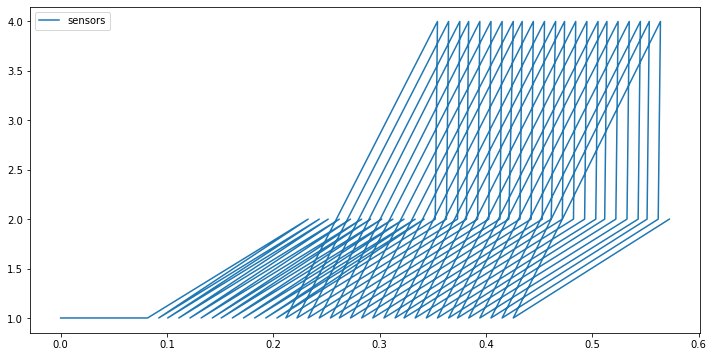

In [28]:
fig = plt.figure(figsize=(12, 6))
plt.plot(data_clean['X'][0][:, 0][:100], data_clean['X'][0][:, 1][:100], label='sensors')
# plt.plot(data_clean['X'][0][:, 0][:100], data_clean['X'][0][:, 2][:100], label='x')
# plt.plot(data_clean['X'][0][:, 0][:100], data_clean['X'][0][:, 3][:100], label='y')
# plt.plot(data_clean['X'][0][:, 0][:100], data_clean['X'][0][:, 4][:100], label='z')
plt.legend()

In [34]:
acc = data_clean['X'][0][np.where(data_clean['X'][0][:, 1] == 1.)]
mag = data_clean['X'][0][np.where(data_clean['X'][0][:, 1] == 2.)]
gyro = data_clean['X'][0][np.where(data_clean['X'][0][:, 1] == 4.)]

In [59]:
data_clean.keys()

dict_keys(['X', 'subject', 'side', 'quality', 'exnum', 'y_labels'])

In [49]:
np.min(data_clean['subje'])

1.0

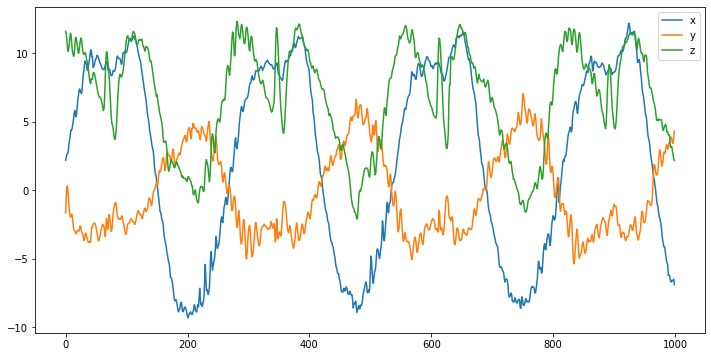

In [40]:
fig = plt.figure(figsize=(12, 6))
# plt.plot(data_clean['X'][0][:, 0][:100], data_clean['X'][0][:, 1][:100], label='sensors')
plt.plot(acc[:, 2][:1000], label='x')
plt.plot(acc[:, 3][:1000], label='y')
plt.plot(acc[:, 4][:1000], label='z')
plt.legend()

In [95]:
# Extract data from monolithic dataset
# Split into num_subjects * num_sensors datasets (1250 * 3 = 3750 csvs)
# Filename template: sensor_subject_side_exercise_quality
# e.g. acc_33_R_8_1.csv

N = len(data_clean['subject'])
headings = ['time', 'x', 'y', 'z']
sensors = {"acc": 1., "mag": 2., "gyro": 4.}
index = 0
for i in range(N):
    for k, v in sensors.items():
        sens = data_clean['X'][i][np.where(data_clean['X'][i][:, 1] == v)]
        sens_df = pd.DataFrame(sens[:, [0, 2, 3, 4]], columns=headings)
        filename = [k,
                    str(int(data_clean['subject'][i])),
                    data_clean['side'][i],
                    str(int(data_clean['exnum'][i])),
                    str(int(data_clean['quality'][i]))]
        filename = "_".join(filename)
        filename += ".csv"
        sens_df.to_csv("./data/" + filename, sep=',', index=False)